<a href="https://colab.research.google.com/github/milorco/Challenge_Telecom-X_Parte-2/blob/main/Telecom_X_Analisis_de_evasion_de_clientes_Parte_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
# Liberías estandar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Funciones de Scikit-Learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split
)

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# Funciones de Yellow Brick
from yellowbrick.target import ClassBalance
from yellowbrick.model_selection import (ValidationCurve, FeatureImportances)
from yellowbrick.classifier.threshold import DiscriminationThreshold
from yellowbrick.classifier import (
    ConfusionMatrix,
    ClassPredictionError,
    ClassificationReport,
    PrecisionRecallCurve,
    ROCAUC,
    ClassPredictionError
)

# Importar xgboost
import xgboost as xgb

# Configurar visualizaciones
sns.set_theme(style="whitegrid")
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%matplotlib inline

# Preparación de los Datos

## Extracción del Archivo Tratado

In [158]:
telecom_x_data = pd.read_csv('/content/drive/MyDrive/datos_tratados.csv')
telecom_x_data.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Monthly,Total,Cuentas_Diarias,Churn_Label
0,0002-ORFBO,0,Female,0,1,1,9,1,0,DSL,0,1,0,1,1,0,One year,1,Mailed check,65.6,593.30,2.197407,Permanecieron
1,0003-MKNFE,0,Male,0,0,0,9,1,1,DSL,0,0,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40,2.008889,Permanecieron
2,0004-TLHLJ,1,Male,0,0,0,4,1,0,Fiber optic,0,0,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.340417,Se dieron de baja
3,0011-IGKFF,1,Male,1,1,0,13,1,0,Fiber optic,0,1,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.173974,Se dieron de baja
4,0013-EXCHZ,1,Female,1,1,0,3,1,0,Fiber optic,0,0,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.971111,Se dieron de baja


## Eliminación de Columnas Irrelevantes

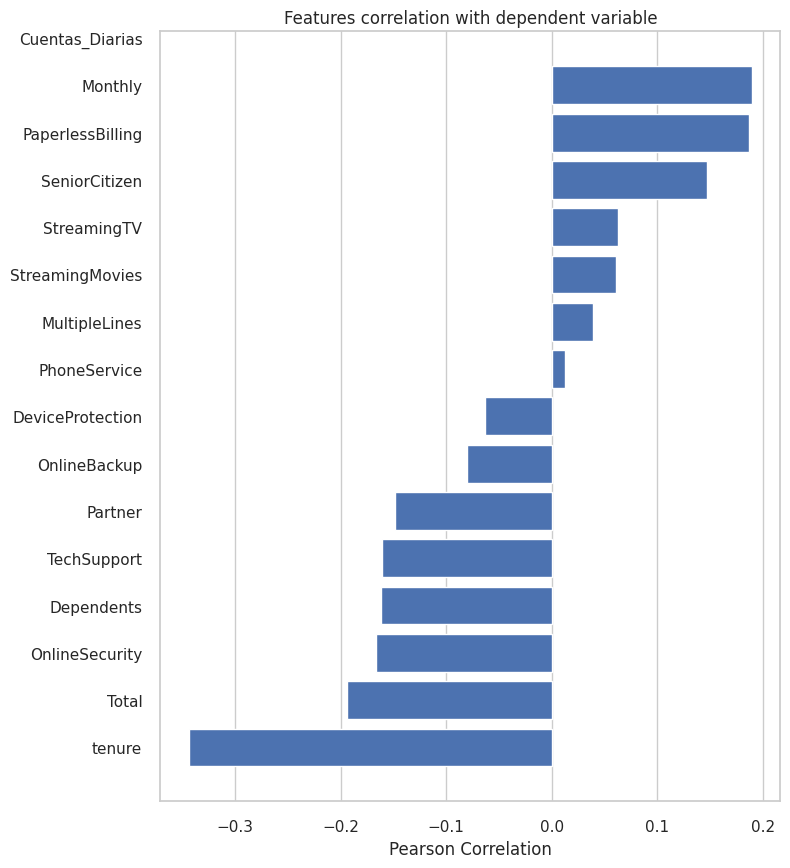

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [160]:
from yellowbrick.target import FeatureCorrelation

# Selecciona las variables numéricas
col_num = (
    telecom_x_data
        .select_dtypes(include = 'number')  # <--- Selecciona las variables numéricas
)

# Calculas las correlaciones y graficalas con
fig, ax = plt.subplots(figsize = (8, 10))
visualizer = FeatureCorrelation(         # <--- Crear la gráfica de feature correlation.
    sort =   True          # <--- Ordena de mayor a menor
)
visualizer.fit(
    col_num.drop(columns = ['Churn']),
    col_num['Churn']
)
visualizer.show()

In [161]:
telecom_x_data.columns

Index(['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Monthly', 'Total',
       'Cuentas_Diarias', 'Churn_Label'],
      dtype='object')

Se eliminaran la columna "customerID" ya que no es relevante.

In [162]:
telecom_x_data = telecom_x_data.drop(columns = 'customerID')

In [163]:
telecom_x_data

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Monthly,Total,Cuentas_Diarias,Churn_Label
0,0,Female,0,1,1,9,1,0,DSL,0,1,0,1,1,0,One year,1,Mailed check,65.60,593.30,2.197407,Permanecieron
1,0,Male,0,0,0,9,1,1,DSL,0,0,0,0,0,1,Month-to-month,0,Mailed check,59.90,542.40,2.008889,Permanecieron
2,1,Male,0,0,0,4,1,0,Fiber optic,0,0,1,0,0,0,Month-to-month,1,Electronic check,73.90,280.85,2.340417,Se dieron de baja
3,1,Male,1,1,0,13,1,0,Fiber optic,0,1,1,0,1,1,Month-to-month,1,Electronic check,98.00,1237.85,3.173974,Se dieron de baja
4,1,Female,1,1,0,3,1,0,Fiber optic,0,0,0,1,1,0,Month-to-month,1,Mailed check,83.90,267.40,2.971111,Se dieron de baja
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,0,Female,0,0,0,13,1,0,DSL,1,0,0,1,0,0,One year,0,Mailed check,55.15,742.90,1.904872,Permanecieron
7263,1,Male,0,1,0,22,1,1,Fiber optic,0,0,0,0,0,1,Month-to-month,1,Electronic check,85.10,1873.70,2.838939,Se dieron de baja
7264,0,Male,0,0,0,2,1,0,DSL,0,1,0,0,0,0,Month-to-month,1,Mailed check,50.30,92.75,1.545833,Permanecieron
7265,0,Male,0,1,1,67,1,0,DSL,1,0,1,1,0,1,Two year,0,Mailed check,67.85,4627.65,2.302313,Permanecieron


## Checar el desbalance en los datos.

In [164]:
(telecom_x_data
     .groupby(['Churn'])
     .size()
     .reset_index(name = 'n_customers')
     .assign(pct = lambda df_: df_.n_customers / df_.n_customers.sum() * 100)
     .round(1)
)

,Churn,n_customers,pct
0,0,5398,74.3
1,1,1869,25.7


[]

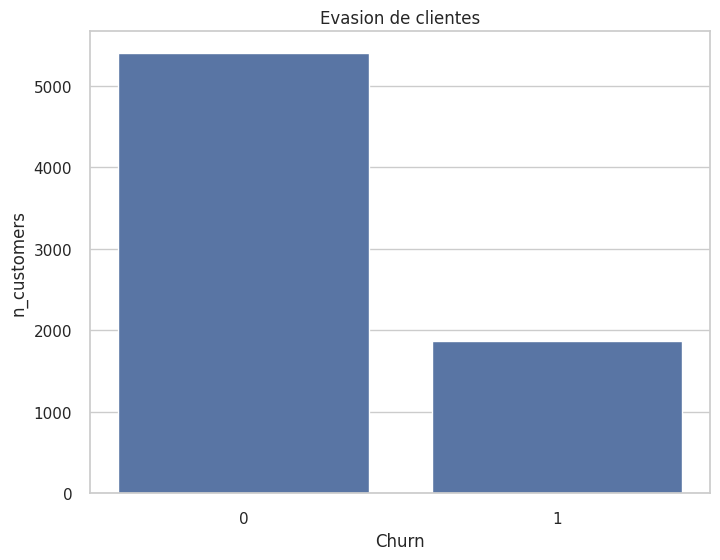

In [165]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.barplot(
    data = (telecom_x_data
            .groupby(['Churn'])
            .size()
            .reset_index(name = 'n_customers')),
    x = 'Churn',
    y = 'n_customers'
)
plt.title("Evasion de clientes")
plt.plot()

## Corregir desbalance con downsampling

In [166]:
# Construimos una función para hacer el downsampling
def fun_downsample(tbl):
    '''
    Función para hacer downsampling
    tbl: Son los datos originales en forma de dataframe.
    '''
    # Filtramos la clase mayoritaria y sacamos de manera aleatoria N observaciones.
    # N es igual al número de observaciones en la clase minoritaria.
    # Se fija una semilla en el random_state para garantizar reproducibilidad.
    tbl_reservations_not_cancelled = (
        tbl
            .query('Churn == 0')
            .sample(
                n = tbl.groupby(['Churn']).size()[1],
                random_state=42)
    )
    # Filtramos la clase minoritaria.
    tbl_reservations_cancelled = tbl.query('Churn == 1')

    return pd.concat([
        tbl_reservations_not_cancelled,
        tbl_reservations_cancelled
    ])

tbl_downsampled_data = fun_downsample(telecom_x_data)

*   Se igualaron las proporciones de las clases a 50:50
*   Desde luego que perdemos mucha información, si embargo, el costo no es superior al beneficio.
*  El beneficio será que nuestro algorítmo será capaz de atrapar más verdaderos positivos que sin debalance.
*  Puede haber casos en los que esto no funcioné y tengamos que aplicar otra distribución, pero por ahora lo dejamos así.






In [167]:
(tbl_downsampled_data
     .groupby(['Churn'])
     .size()
     .reset_index(name = 'n_customers')
     .assign(pct = lambda df_: df_.n_customers / df_.n_customers.sum() * 100)
     .round(1)
)

,Churn,n_customers,pct
0,0,1869,50.0
1,1,1869,50.0


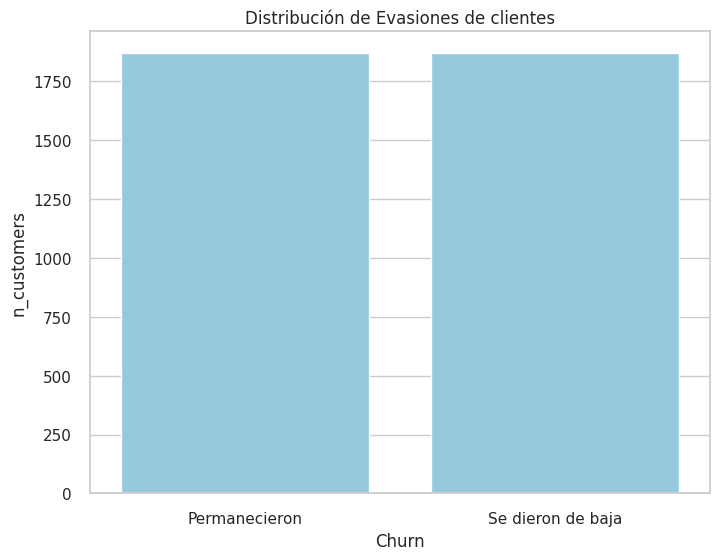

In [168]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.barplot(
    data = (tbl_downsampled_data
            .groupby(['Churn'])
            .size()
            .reset_index(name = 'n_customers')
            .assign(Churn = lambda df_: df_.Churn.replace({0: 'Permanecieron', 1: 'Se dieron de baja'}))),
    x = 'Churn',
    y = 'n_customers',
    color = 'skyblue'
)
plt.title("Distribución de Evasiones de clientes")
plt.show()

# Construimos los conjuntos de entrenamiento

Para construir los conjuntos de entrenamiento y prueba usamos tbl_downsampled_data los nuevos datos y no telecom_x_data que son los datos originales.

In [169]:
from sklearn.model_selection import train_test_split

y = tbl_downsampled_data.Churn
X = tbl_downsampled_data.drop(columns = 'Churn')

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [170]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (2990, 21)
y_train shape: (2990,)


In [171]:
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_test shape: (748, 21)
y_test shape: (748,)


## Paso 1. Selecciona y extrae las características de tu modelo.

In [172]:
X_train.nunique()

,0
gender,2
SeniorCitizen,2
Partner,2
Dependents,2
tenure,73
PhoneService,2
MultipleLines,2
InternetService,3
OnlineSecurity,2
OnlineBackup,2


In [173]:
fun_downsample(telecom_x_data)

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Monthly,Total,Cuentas_Diarias,Churn_Label
3375,0,Female,0,0,0,21,1,1,Fiber optic,0,1,0,0,1,1,Month-to-month,1,Credit card (automatic),99.85,1992.55,3.162778,Permanecieron
1422,0,Male,0,1,0,1,1,0,DSL,1,0,1,0,0,0,Month-to-month,0,Mailed check,55.70,55.70,1.856667,Permanecieron
4310,0,Male,0,0,0,2,1,0,No,0,0,0,0,0,0,Month-to-month,0,Mailed check,20.05,42.70,0.711667,Permanecieron
3221,0,Male,0,1,1,23,1,1,DSL,0,1,0,1,0,0,Two year,0,Mailed check,59.70,1414.20,2.049565,Permanecieron
2858,0,Female,1,0,0,3,1,0,Fiber optic,0,0,1,0,0,0,Month-to-month,0,Mailed check,75.05,202.90,2.254444,Permanecieron
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7243,1,Male,1,0,0,21,1,0,Fiber optic,0,0,1,0,1,1,Month-to-month,1,Bank transfer (automatic),96.80,2030.30,3.222698,Se dieron de baja
7246,1,Male,1,0,0,9,1,1,Fiber optic,0,0,0,0,0,1,Month-to-month,1,Electronic check,83.85,790.15,2.926481,Se dieron de baja
7260,1,Female,0,0,0,1,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Mailed check,70.15,70.15,2.338333,Se dieron de baja
7261,1,Female,0,0,0,4,1,0,No,0,0,0,0,0,0,Month-to-month,0,Bank transfer (automatic),20.95,85.50,0.712500,Se dieron de baja


In [174]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2990 entries, 331 to 4959
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            2990 non-null   object 
 1   SeniorCitizen     2990 non-null   int64  
 2   Partner           2990 non-null   int64  
 3   Dependents        2990 non-null   int64  
 4   tenure            2990 non-null   int64  
 5   PhoneService      2990 non-null   int64  
 6   MultipleLines     2990 non-null   int64  
 7   InternetService   2990 non-null   object 
 8   OnlineSecurity    2990 non-null   int64  
 9   OnlineBackup      2990 non-null   int64  
 10  DeviceProtection  2990 non-null   int64  
 11  TechSupport       2990 non-null   int64  
 12  StreamingTV       2990 non-null   int64  
 13  StreamingMovies   2990 non-null   int64  
 14  Contract          2990 non-null   object 
 15  PaperlessBilling  2990 non-null   int64  
 16  PaymentMethod     2990 non-null   object 
 17

In [390]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np

variable_selection_numeric = [  'SeniorCitizen', 'tenure', 'OnlineSecurity',
                                'TechSupport', 'PaperlessBilling', 'Total']
variable_selection_categoric = ['InternetService', 'Contract', 'PaymentMethod'] # <--- Selecciona las variable categóricas

def prep_for_ml(tbl_train, tbl_test):
    '''Clean X_train and X_test
        1) Select continuous and categorical variables.
        2) Convert categorical variables to one hot encoding
        3) Concatenate clean dataframes
    '''
    # Continuous variables
    tbl_num_train = tbl_train.loc[:, variable_selection_numeric]
    tbl_num_test = tbl_test.loc[:, variable_selection_numeric]

    # Check for non-finite values before scaling
    if not np.isfinite(tbl_num_train).all().all():
        print("Non-finite values found in numerical training data before scaling:")
        print(tbl_num_train[~np.isfinite(tbl_num_train)].stack())
        # Option to handle these values, e.g., drop or impute, could be added here
        # For now, we'll just print and let the error occur to see the values

    # Scale numerical features
    scaler = StandardScaler()
    tbl_num_train_scaled = scaler.fit_transform(tbl_num_train)
    tbl_num_test_scaled = scaler.transform(tbl_num_test)

    tbl_num_train_scaled = pd.DataFrame(tbl_num_train_scaled, columns=variable_selection_numeric)
    tbl_num_test_scaled = pd.DataFrame(tbl_num_test_scaled, columns=variable_selection_numeric)


    # Categorical variables
    tbl_cat_train = tbl_train.loc[:, variable_selection_categoric]
    tbl_cat_test = tbl_test.loc[:, variable_selection_categoric]

    ohe = OneHotEncoder(drop = 'first')
    ohe.fit(tbl_cat_train)
    col_names = ohe.get_feature_names_out()

    tbl_ohe_cat_train = pd.DataFrame(
        ohe.transform( tbl_cat_train ).toarray()
    )

    tbl_ohe_cat_test = pd.DataFrame(
        ohe.transform( tbl_cat_test ).toarray()
    )
    # Add new column names
    tbl_ohe_cat_train.columns = col_names
    tbl_ohe_cat_test.columns = col_names

    # Join transformed continuous + categorical variables
    tbl_train_clean = pd.concat([tbl_num_train_scaled.reset_index(drop = True), tbl_ohe_cat_train], axis = 1)
    tbl_test_clean = pd.concat([tbl_num_test_scaled.reset_index(drop = True), tbl_ohe_cat_test], axis = 1)

    return (tbl_train_clean, tbl_test_clean)

X_train_clean, X_test_clean = prep_for_ml(X_train, X_test)

In [291]:
print(f'X_train_clean shape: {X_train_clean.shape}')
print(f'y_train shape: {y_train.shape}')

X_train_clean shape: (2990, 13)
y_train shape: (2990,)


In [292]:
print(f'X_test_clean shape: {X_test_clean.shape}')
print(f'y_test shape: {y_test.shape}')

X_test_clean shape: (748, 13)
y_test shape: (748,)


In [293]:
assert list(X_train_clean.columns) == list(X_test_clean.columns)

In [294]:
X_test_clean.columns

Index(['SeniorCitizen', 'tenure', 'OnlineSecurity', 'TechSupport',
       'PaperlessBilling', 'Total', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [295]:
X_train_clean

,SeniorCitizen,tenure,OnlineSecurity,TechSupport,PaperlessBilling,Total,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.485848,0.191851,-0.582242,-0.569884,0.747063,0.003317,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.485848,-1.105869,-0.582242,-0.569884,-1.338575,-0.913607,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.485848,0.652332,-0.582242,1.754744,0.747063,1.029760,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.485848,1.740742,-0.582242,-0.569884,0.747063,0.824971,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,-0.485848,0.610470,-0.582242,-0.569884,0.747063,-0.540783,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,2.058258,1.866328,1.717499,1.754744,0.747063,1.272681,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2986,-0.485848,1.112813,-0.582242,1.754744,0.747063,1.175522,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2987,-0.485848,0.903504,1.717499,-0.569884,0.747063,1.326322,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2988,-0.485848,-0.980283,-0.582242,-0.569884,0.747063,-0.879394,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<Axes: >

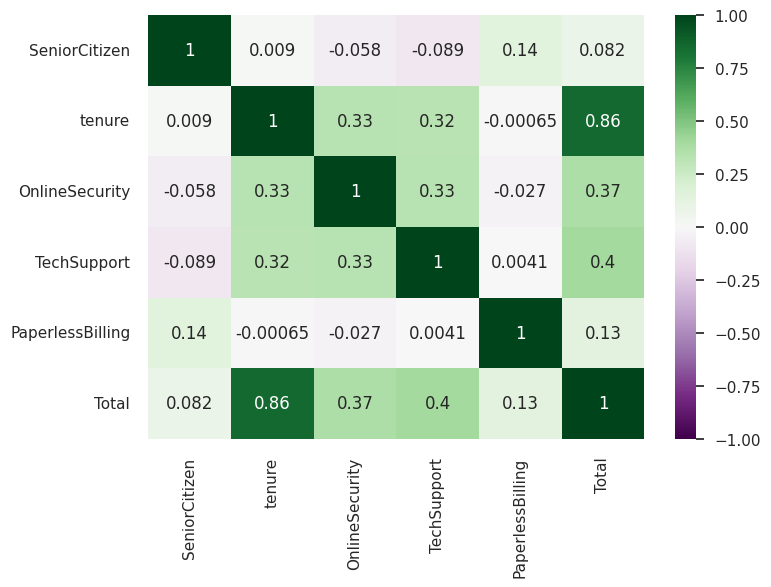

In [296]:
sns.heatmap(
    X_train.loc[:, variable_selection_numeric].corr(),
    annot = True,
    vmin = -1,
    vmax = 1,
    center = 0,
    cmap = 'PRGn'
)

## Paso 2: Construye un modelo base

### Logistic Regression

In [297]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

lr_model = LogisticRegression(random_state=0).fit(X_train_clean, y_train)
lr_model.predict_proba(X_test_clean)

y_pred = lr_model.predict(X_test_clean)
y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,

### Confusion Matrix

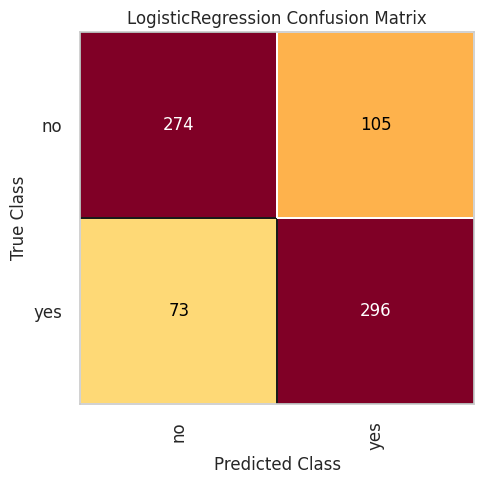

In [298]:
from yellowbrick.classifier import ConfusionMatrix
fig, ax = plt.subplots(figsize = (5,5))
# Creamos la matrix de confusión
cm = ConfusionMatrix(
    lr_model, 				# Pasar el estimador del mejor modelo que
    							# se obtiene de la validación cruzada.
    classes=['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
cm.fit(X_train_clean, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
cm.score(X_test_clean, y_test)
# Dibjuamos la visualización.
cm.show();

In [299]:
from sklearn.metrics import precision_score, recall_score, f1_score
def fun_imprimir_metricas_de_evaluacion(y_true, y_pred):
    '''Imprimer los resultados de precision, recall y f1 score

    Implementa las métricas de precision, recall y f1 score de
    sklearn para la categoría 1= sí acepta el depósito a plazo.

    Parameters
    ----------
    y_true (ndarray): Array con las clases actuales
    y_pred (ndarray): Array con las clases predichas
    '''
    print("precision_score: {}".format(np.round(precision_score(y_true, y_pred), 3)))
    print("recall_score: {}".format(np.round(recall_score(y_true, y_pred), 3)))
    print("f1_score: {}".format(np.round(f1_score(y_true, y_pred), 3)))

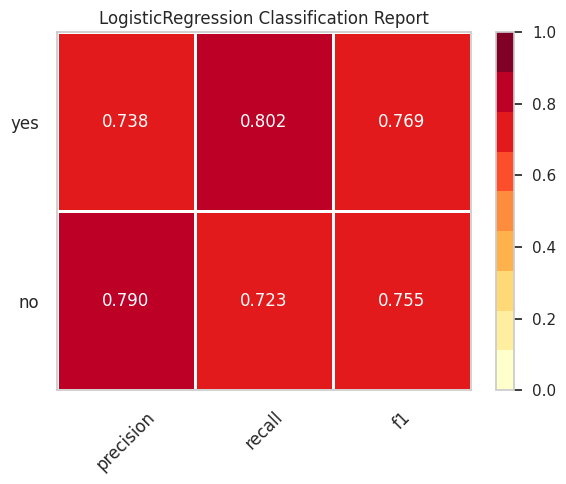

In [300]:
from yellowbrick.classifier import ClassificationReport
fig, ax = plt.subplots(figsize = (6,5))
visualizer = ClassificationReport(
    lr_model,					# Pasar el estimador del mejor modelo que
    							# se obtiene de la validación cruzada.
    classes=['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
visualizer.fit(X_train_clean, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
visualizer.score(X_test_clean, y_test)
# Dibjuamos la visualización.
visualizer.show();

In [301]:
fun_imprimir_metricas_de_evaluacion(y_test, y_pred)

precision_score: 0.738
recall_score: 0.802
f1_score: 0.769


## Paso 3: Buscar los mejores hiperparámetros de tu modelo

### REGRESION LOGISTICA

In [302]:
seed = 42

In [303]:
from sklearn.model_selection import RandomizedSearchCV
lr = LogisticRegression(random_state = seed, class_weight='balanced')

params = {
    'C': np.logspace(1, 2, 10),
    'solver': ['newton-cg', 'liblinear', 'sag'],
    'penalty': ['l2', 'l1']
}

random_search = RandomizedSearchCV(
    lr_model,
    param_distributions=params,                 # <--- Pasa el grid de parámetros
    n_iter = 5,                                # <--- Declara cuántas combinaciones quieres explorar
    cv = 10,                                     # <--- Declara las k-particiones de validación cruzada
    random_state = seed                         # <--- Declara una semilla

)

random_search.fit(X_train_clean, y_train)       # <--- Entrena los modelos
y_pred = random_search.predict(X_test_clean)

In [304]:
lr_best_model = random_search.best_estimator_
lr_best_model

LogisticRegression(C=np.float64(46.41588833612777), random_state=0,
                   solver='newton-cg')

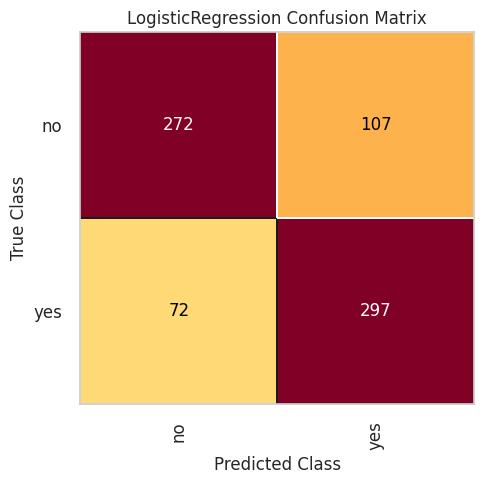

In [305]:
from yellowbrick.classifier import ConfusionMatrix
fig, ax = plt.subplots(figsize = (5,5))
# Creamos la matrix de confusión
cm = ConfusionMatrix(
    lr_best_model, 				# Pasar el estimador del mejor modelo que
    							# se obtiene de la validación cruzada.
    classes=['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
cm.fit(X_train_clean, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
cm.score(X_test_clean, y_test)
# Dibjuamos la visualización.
cm.show();

In [306]:
fun_imprimir_metricas_de_evaluacion(y_test, y_pred)

precision_score: 0.735
recall_score: 0.805
f1_score: 0.768


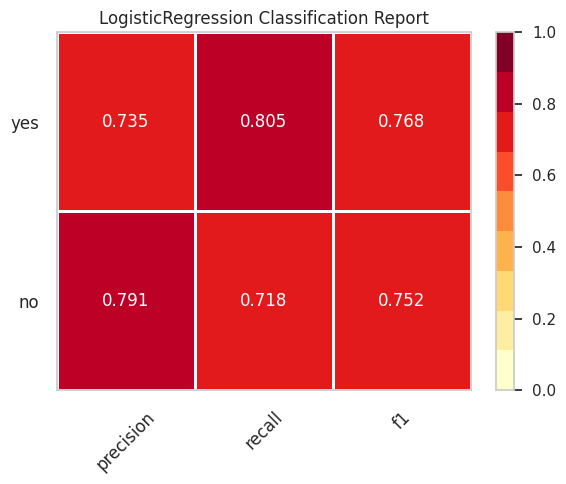

In [307]:
from yellowbrick.classifier import ClassificationReport
fig, ax = plt.subplots(figsize = (6,5))
visualizer = ClassificationReport(
    lr_best_model,					# Pasar el estimador del mejor modelo que
    							# se obtiene de la validación cruzada.
    classes=['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
visualizer.fit(X_train_clean, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
visualizer.score(X_test_clean, y_test)
# Dibjuamos la visualización.
visualizer.show();

## Paso 4: Prueba con otro modelo y ajuste de sus hiperparámetros

In [308]:
from sklearn.ensemble import RandomForestClassifier

# Especificamos un modelo de árbol de decisión

rfc_model = RandomForestClassifier(max_depth=2, random_state=0)

# Ajustamos el modelo y predecimos

rfc_model.fit(
    X_train_clean,
    y_train
)

y_pred = rfc_model.predict(X_test_clean)

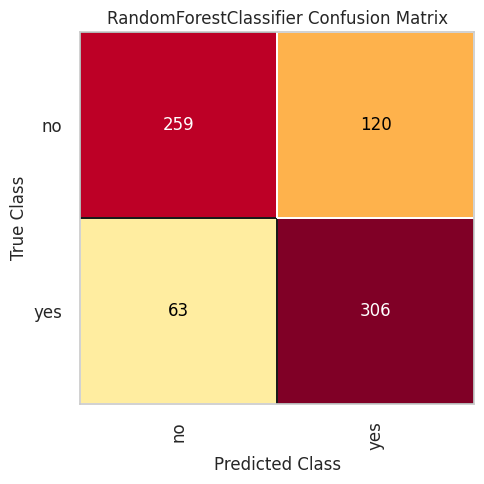

In [309]:
from yellowbrick.classifier import ConfusionMatrix
fig, ax = plt.subplots(figsize = (5,5))
# Creamos la matrix de confusión
cm = ConfusionMatrix(
    rfc_model, 				# Pasar el estimador del mejor modelo que
    							# se obtiene de la validación cruzada.
    classes=['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
cm.fit(X_train_clean, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
cm.score(X_test_clean, y_test)
# Dibjuamos la visualización.
cm.show();

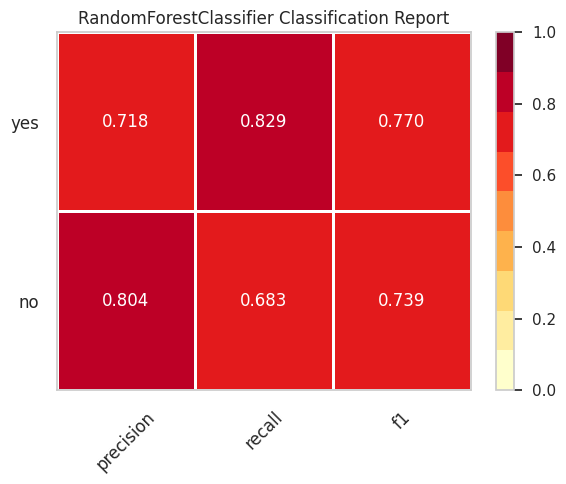

In [310]:
from yellowbrick.classifier import ClassificationReport
fig, ax = plt.subplots(figsize = (6,5))
visualizer = ClassificationReport(
    rfc_model,					# Pasar el estimador del mejor modelo que
    							# se obtiene de la validación cruzada.
    classes=['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
visualizer.fit(X_train_clean, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
visualizer.score(X_test_clean, y_test)
# Dibjuamos la visualización.
visualizer.show();

In [386]:
rfc_model = RandomForestClassifier(random_state = seed)

params = {
    'n_estimators': [750, 770, 800],
    'max_depth': [5, 8, 15, 25, 30, None],
    'min_samples_split': [1, 2, 5, 10, 15, 100],
    'max_features': ['log2', 'sqrt', None]
}

random_search = RandomizedSearchCV(
    rfc_model,
    param_distributions=params,                 # <--- Pasa el grid de parámetros
    n_iter = 2,                                # <--- Declara cuántas combinaciones quieres explorar
    cv = 5,                                     # <--- Declara las k-particiones de validación cruzada
    random_state = seed                         # <--- Declara una semilla

)

random_search.fit(X_train_clean, y_train)       # <--- Entrena los modelos
y_pred = random_search.predict(X_test_clean)

In [387]:
rfc_best_model = random_search.best_estimator_
rfc_best_model

RandomForestClassifier(max_depth=8, max_features=None, min_samples_split=15,
                       n_estimators=750, random_state=42)

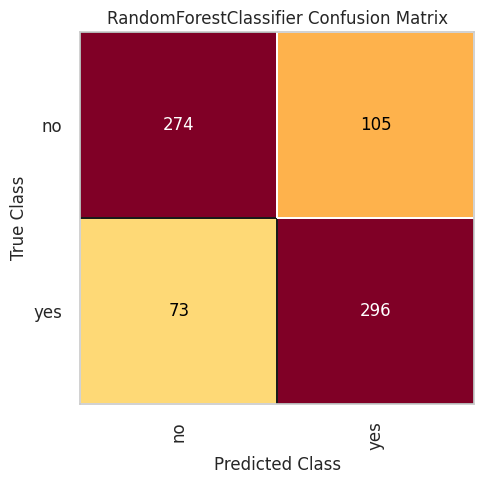

In [388]:
from yellowbrick.classifier import ConfusionMatrix
fig, ax = plt.subplots(figsize = (5,5))
# Creamos la matrix de confusión
cm = ConfusionMatrix(
    rfc_best_model, 				# Pasar el estimador del mejor modelo que
    							# se obtiene de la validación cruzada.
    classes=['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
cm.fit(X_train_clean, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
cm.score(X_test_clean, y_test)
# Dibjuamos la visualización.
cm.show();

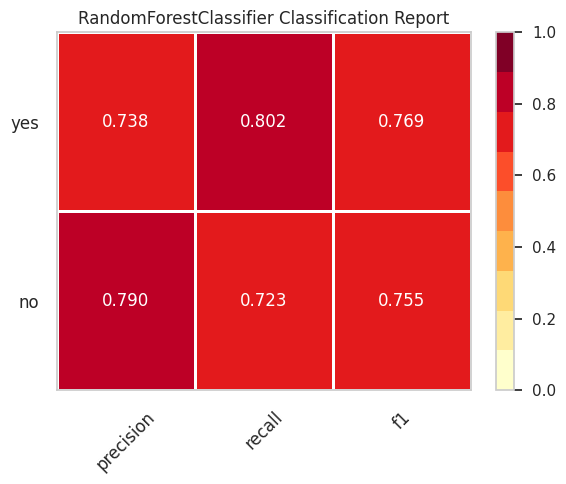

In [389]:
from yellowbrick.classifier import ClassificationReport
fig, ax = plt.subplots(figsize = (6,5))
visualizer = ClassificationReport(
    rfc_best_model,					# Pasar el estimador del mejor modelo que
    							# se obtiene de la validación cruzada.
    classes=['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
visualizer.fit(X_train_clean, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
visualizer.score(X_test_clean, y_test)
# Dibjuamos la visualización.
visualizer.show();

### DECISION TREE CLASSIFIER

In [315]:
from sklearn.tree import DecisionTreeClassifier

# Especificamos un modelo de árbol de decisión

dtc_model = DecisionTreeClassifier(random_state=seed)

# Ajustamos el modelo y predecimos

dtc_model.fit(
    X_train_clean,
    y_train
)

y_pred = dtc_model.predict(X_test_clean)

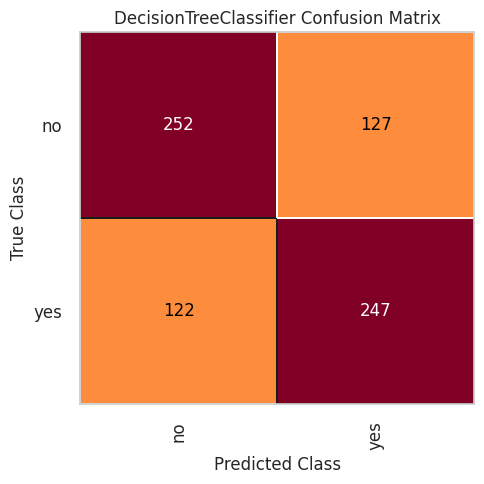

In [316]:
from yellowbrick.classifier import ConfusionMatrix
fig, ax = plt.subplots(figsize = (5,5))
# Creamos la matrix de confusión
cm = ConfusionMatrix(
    dtc_model, 				# Pasar el estimador del mejor modelo que
    							# se obtiene de la validación cruzada.
    classes=['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
cm.fit(X_train_clean, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
cm.score(X_test_clean, y_test)
# Dibjuamos la visualización.
cm.show();

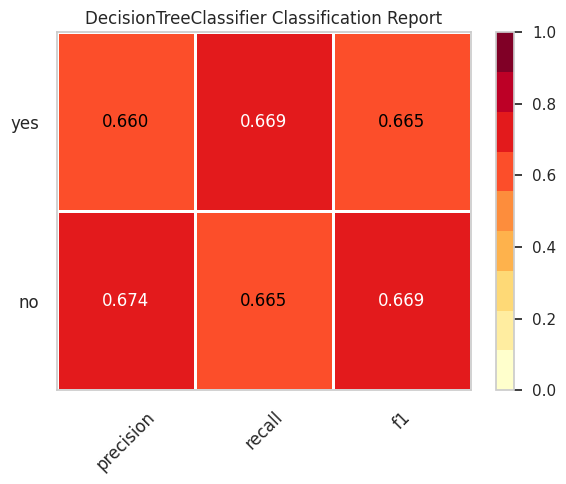

In [317]:
from yellowbrick.classifier import ClassificationReport
fig, ax = plt.subplots(figsize = (6,5))
visualizer = ClassificationReport(
    dtc_model,					# Pasar el estimador del mejor modelo que
    							# se obtiene de la validación cruzada.
    classes=['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
visualizer.fit(X_train_clean, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
visualizer.score(X_test_clean, y_test)
# Dibjuamos la visualización.
visualizer.show();

In [318]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
# Especificamos un modelo de árbol de decisión
dtc_model = DecisionTreeClassifier(
    class_weight = 'balanced', 	# Indicamos que se deben reponderar las clases.
    random_state=seed			# Indicamos una semilla para reproducibilidad.
)

# Especificar diccionario de parámteros y valores a explorar
params = {
    'max_depth':[5, 10, 50, 100, 150, 200],
    'min_samples_split':[2, 4, 6, 8],
    'min_samples_leaf':[1, 2, 4, 5]
}
# Especificar opciones del Grid Search
grid_search = GridSearchCV(
    dtc_model, 				# Indicar el modelo (debe ser un estimador).
    scoring = 'roc_auc', 	# Indicar la métrica para evaluar el desempeño del
    						# modelo en validación cruzada.
    param_grid=params, 		# Indicar el diccionario de parámetros y valores
    cv = 10, 				# Indicar los k cortes de validación cruzada.
    return_train_score=True,# Agregar el error de entrenamiento
    n_jobs = -1				# Indicar cuántos CPUs utilizar para paralelizar el
    						# trabajo.

)
# Entrenar los modelos
grid_search.fit(X_train_clean, y_train)

GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 50, 100, 150, 200],
                         'min_samples_leaf': [1, 2, 4, 5],
                         'min_samples_split': [2, 4, 6, 8]},
             return_train_score=True, scoring='roc_auc')

In [319]:
dtc_best_model = grid_search.best_estimator_
dtc_best_model

DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=5,
                       random_state=42)

### Matriz de confusion

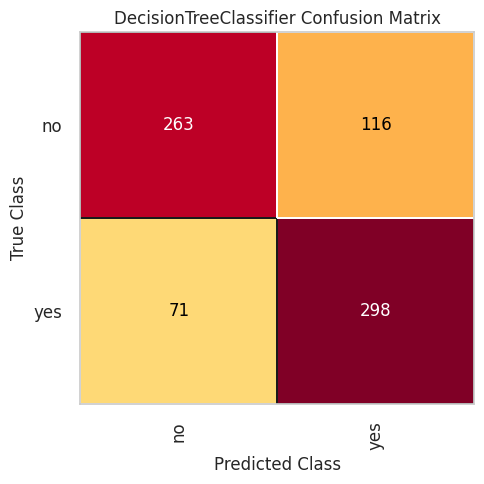

In [320]:
from yellowbrick.classifier import ConfusionMatrix
fig, ax = plt.subplots(figsize = (5,5))
# Creamos la matrix de confusión
cm = ConfusionMatrix(
    dtc_best_model, 				# Pasar el estimador del mejor modelo que
    							# se obtiene de la validación cruzada.
    classes=['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
cm.fit(X_train_clean, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
cm.score(X_test_clean, y_test)
# Dibjuamos la visualización.
cm.show();

### Classification Report

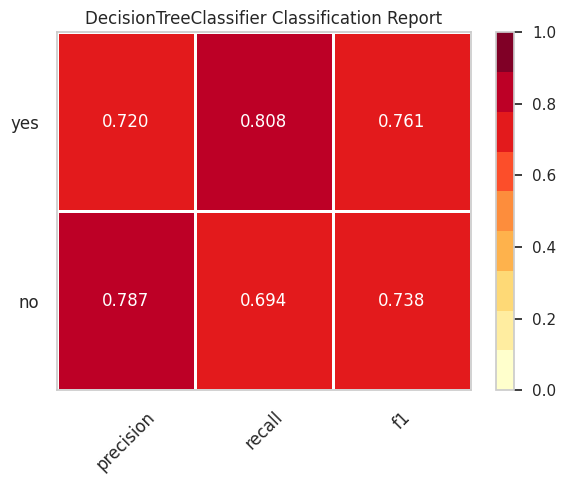

In [321]:
from yellowbrick.classifier import ClassificationReport
fig, ax = plt.subplots(figsize = (6,5))
visualizer = ClassificationReport(
    dtc_best_model,					# Pasar el estimador del mejor modelo que
    							# se obtiene de la validación cruzada.
    classes=['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
visualizer.fit(X_train_clean, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
visualizer.score(X_test_clean, y_test)
# Dibjuamos la visualización.
visualizer.show();

## Paso 5: Seleccion del mejor modelo y calcular las predicciones

De acuerdo al analisis del mejor modelo, se obtuvieron mejores resltados con LogisticsRegression. Por lo que se tomara ese modelo como el mejor para los siguientes pasos.

In [322]:
best_model = lr_best_model

### Prediccion de la clase

In [323]:
# Utilizar el mejor modelo para predecir la clase
y_pred = best_model.predict(X_test_clean)
# Mostrar las clases de los primeros 20 clientes
y_pred[:20]

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1])

### Prediccion de la probabilidad de cancelacion

In [324]:
# Utilizar el mejor modelo para predecir la probabilidad.
y_pred_proba = best_model.predict_proba(X_test_clean)[:,1]
# Mostrar las probabilidades de los primeros 20 clientes
y_pred_proba[:20]

array([0.07481962, 0.34894164, 0.37668117, 0.04949216, 0.85883121,
       0.18579422, 0.36148156, 0.24346998, 0.89270635, 0.5586518 ,
       0.04478475, 0.87977843, 0.86705113, 0.01226827, 0.06345604,
       0.48608611, 0.85531769, 0.90809156, 0.1302419 , 0.89507787])

### Evaluacion de ajuste

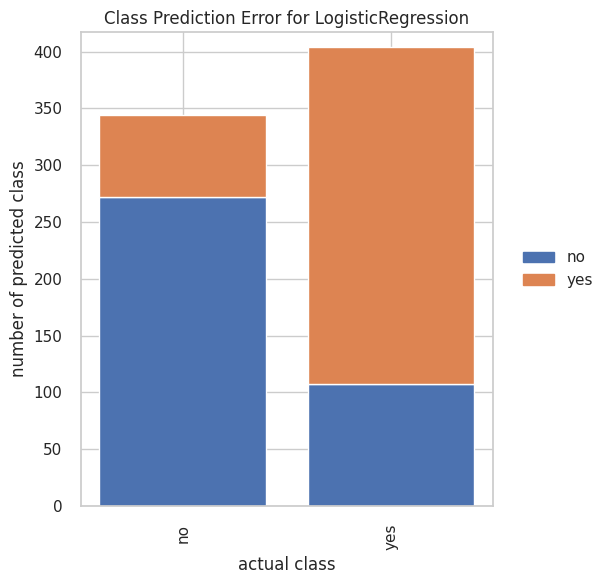

In [325]:
from yellowbrick.classifier import ClassPredictionError
# Creamos la figura
fig, ax = plt.subplots(figsize = (7,6))
cpe_viz = ClassPredictionError(
    best_model,					# Pasar el estimador del mejor modelo que
    							# se obtiene de la validación cruzada.
    classes = ['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
cpe_viz.fit(X_train_clean, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
cpe_viz.score(X_test_clean, y_test)
# Dibjuamos la visualización.
cpe_viz.show();

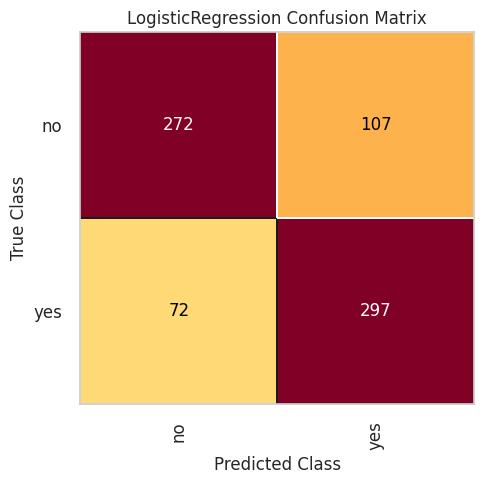

In [326]:
from yellowbrick.classifier import ConfusionMatrix
fig, ax = plt.subplots(figsize = (5,5))
# Creamos la matrix de confusión
cm = ConfusionMatrix(
    best_model, 				# Pasar el estimador del mejor modelo que
    							# se obtiene de la validación cruzada.
    classes=['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
cm.fit(X_train_clean, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
cm.score(X_test_clean, y_test)
# Dibjuamos la visualización.
cm.show();

In [327]:
# Matriz de confusión implementación de Sklearn
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[272, 107],
       [ 72, 297]])

## Selección del punto de corte

### Threshold Plot

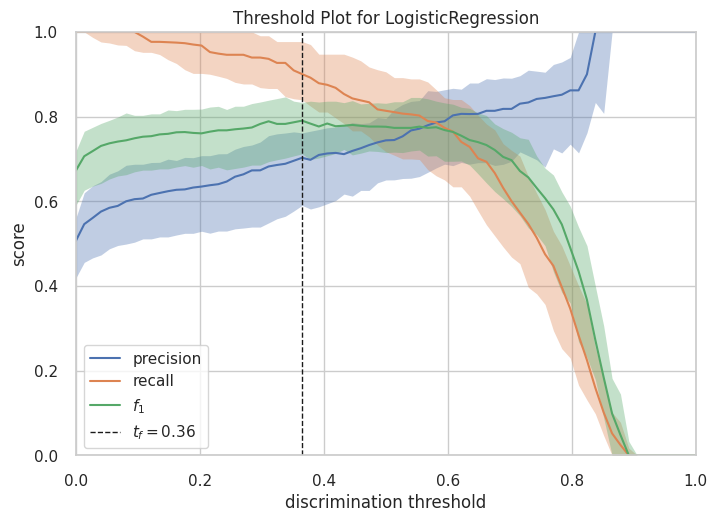

In [328]:
from yellowbrick.classifier.threshold import DiscriminationThreshold
# Especificamos la gráfica
visualizer = DiscriminationThreshold(
	best_model,							# Pasar el estimador del mejor modelo que
    									# se obtiene de la validación cruzada.
	exclude = ["queue_rate"]			# Excluimos de la gráfica algunas métricas
)
# Ajustamos la visualización a los datos de entrenamiento
visualizer.fit(X_test_clean, y_test)
# Dibjuamos la visualización.
visualizer.show();

In [329]:
# Clasificar con un punto de corte más alto que 0.5
def fun_predict_with_threshold(model, threshold = 0.31):
    '''Predice la clase del cliente utilizando un threshold

    Permite predecir la clase de un cliente utilizando otros
    puntos de corte (threshold) que sean diferentes a 0.5.

    Parameters
    ----------
    model: Fitted estimator
    threshold (float): Punto de corte entre 0 y 1.

    Returns
    -------
    ndarray:
        Regresa un numpy array con el valor de la clase 0 ó 1
    '''
    return np.where( model.predict_proba(X_test_clean)[:,1] < threshold, 0, 1 )

In [330]:
# Calcular clases con un punto de corte en 0.31
y_pred_031 = fun_predict_with_threshold(best_model, threshold = 0.31)
# Mostrar primeros 20 clientes
y_pred_031[:20]

array([0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1])

## Reporte de clasificación, recall, precision y f1-score

In [331]:
from sklearn.metrics import precision_score, recall_score, f1_score
def fun_imprimir_metricas_de_evaluacion(y_true, y_pred):
    '''Imprimer los resultados de precision, recall y f1 score

    Implementa las métricas de precision, recall y f1 score de
    sklearn para la categoría 1= sí acepta el depósito a plazo.

    Parameters
    ----------
    y_true (ndarray): Array con las clases actuales
    y_pred (ndarray): Array con las clases predichas
    '''
    print("precision_score: {}".format(np.round(precision_score(y_true, y_pred), 3)))
    print("recall_score: {}".format(np.round(recall_score(y_true, y_pred), 3)))
    print("f1_score: {}".format(np.round(f1_score(y_true, y_pred), 3)))

In [332]:
fun_imprimir_metricas_de_evaluacion(y_test, y_pred)

precision_score: 0.735
recall_score: 0.805
f1_score: 0.768


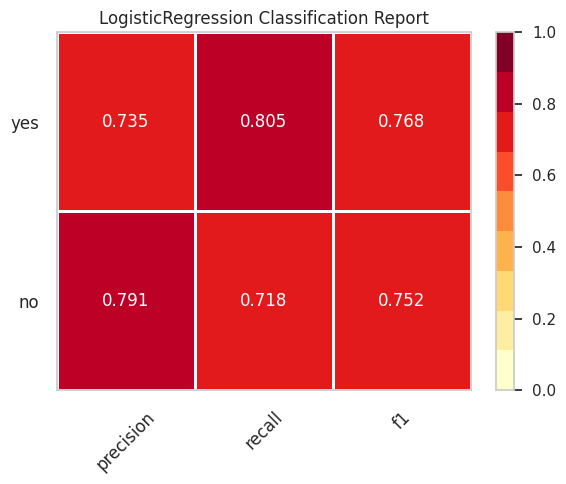

In [333]:
from yellowbrick.classifier import ClassificationReport
fig, ax = plt.subplots(figsize = (6,5))
visualizer = ClassificationReport(
    best_model,					# Pasar el estimador del mejor modelo que
    							# se obtiene de la validación cruzada.
    classes=['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
visualizer.fit(X_train_clean, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
visualizer.score(X_test_clean, y_test)
# Dibjuamos la visualización.
visualizer.show();

## Curva ROC del mejor modelo

### ROC AUC

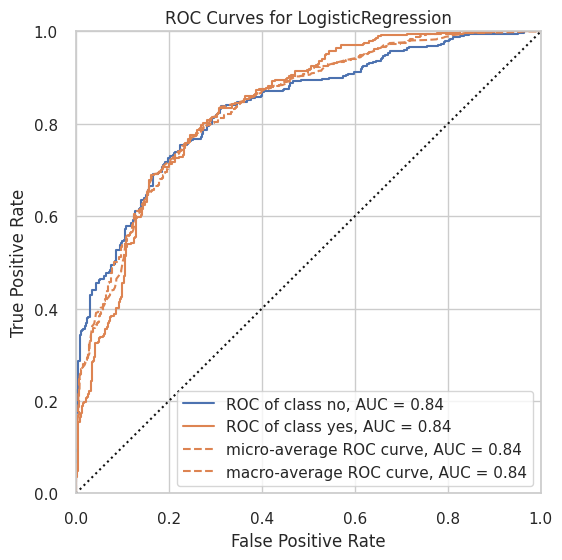

In [334]:
from yellowbrick.classifier import ROCAUC
# Especificamos la curva ROC AUC
fig, ax = plt.subplots(figsize = (6,6))
roc_curves_visualizer = ROCAUC(
    best_model,					# Pasar el estimador del mejor modelo que
    							# se obtiene de la validación cruzada.
    classes=['no', 'yes']		# Indicar las etiquetas de las clases.
    							# Cuidado con el orden de los nombres.
)
# Ajustamos la visualización a los datos de entrenamiento
roc_curves_visualizer.fit(X_train_clean, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
roc_curves_visualizer.score(X_test_clean, y_test)
# Dibjuamos la visualización.
roc_curves_visualizer.show();

### precision y el recall.

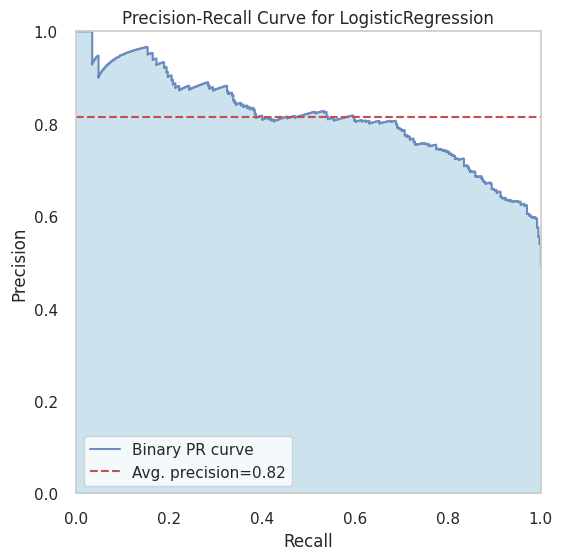

In [335]:
from yellowbrick.classifier import PrecisionRecallCurve
# Especificamos la curva de precision y recall
fig, ax = plt.subplots(figsize = (6,6))
viz = PrecisionRecallCurve(best_model) 			# Pasamos el estimado del mejor modelo
												# que obtuvimos con validación cruzada.
# Ajustamos la visualización con los
# datos de entrenamiento
viz.fit(X_train_clean, y_train)
# Evaluamos con los datos de prueba
viz.score(X_test_clean, y_test)
# Dibujamos la visualización
viz.show();

In [336]:
from sklearn.metrics import roc_auc_score
# Implementación de las métricas con sklearn
print("roc_auc_score: {}".format(np.round(roc_auc_score(y_test, y_pred_proba), 3)))

roc_auc_score: 0.836


### Visualizar la importancia de características (Feature Importances)

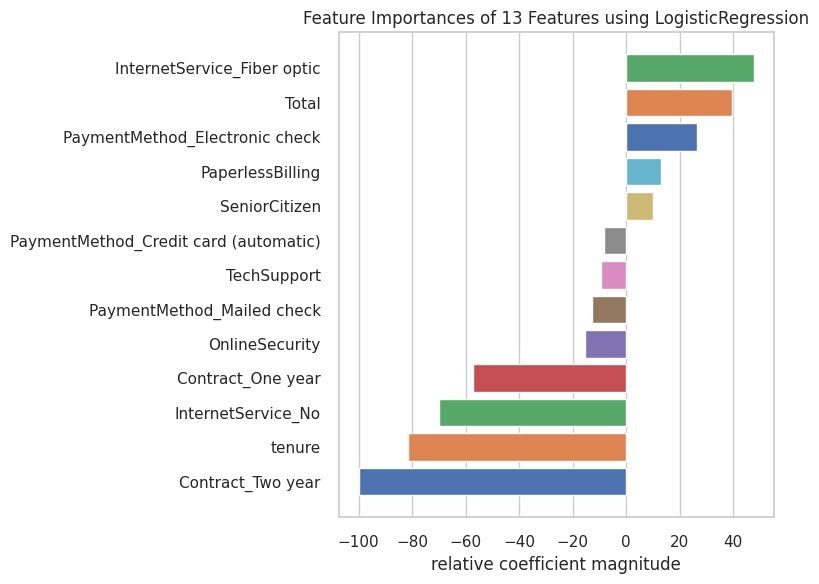

In [337]:
from yellowbrick.model_selection import FeatureImportances
# Especificamos la gráfica
fig, ax = plt.subplots(figsize = (8,6))
viz = FeatureImportances(best_model) 	# Pasar el estimador del mejor modelo que
    									# se obtiene de la validación cruzada.
# Ajustamos la visualización a los datos de entrenamiento
viz.fit(X_train_clean, y_train)
# Dibjuamos la visualización.
viz.show();

# Conclusion

## * El modelo parece ser bastante bueno prediciendo correctamente los clientes que cancelaran.
## * Las variables 'Contact_Two year' y 'tenure' parecen afectar en mayor medida en la decision del cliente para cancelar la reservacion.

# INFORME de Cancelacion de clientes

## **1) Resumen ejecutivo**

**Mejor modelo:** Regresión Logística (seleccionada como best_model = lr_best_model).

**Rendimiento en test:**

**Precision** ≈ 0.735

**Recall** ≈ 0.805

**F1** ≈ 0.768

**ROC AUC** ≈ 0.836

**Drivers clave de cancelación** (según variables seleccionadas y el mejor modelo):

**Tipo de contrato:** los contratos mes a mes elevan el riesgo; Two year reduce fuertemente la cancelación.

**Tenure (antigüedad):** menor tenure = mayor probabilidad de cancelar; tenure alto protege.

**Servicios de seguridad/soporte:** sin OnlineSecurity y/o sin TechSupport incrementa el churn; contar con ellos lo reduce.

**InternetService:** perfiles (p. ej., Fiber optic) suelen mostrar más cancelación si no van acompañados de valor percibido/soporte.

**PaymentMethod:** métodos como electronic check suelen asociarse a mayor churn; pagos automáticos tienden a estabilizar.

**PaperlessBilling:** según combinación con método de pago/contrato, puede asociarse con mayor o menor riesgo (suele elevar riesgo si va con electronic check).

**SeniorCitizen:** muestra señal de mayor risk (necesita atención y servicio adaptado).

**Total (gasto):** tickets altos sin contraprestación percibida aumentan el riesgo.


## 2) Datos y variables utilizadas

Selección aplicada en el preprocesamiento (one-hot encoding para categóricas, estandarización para numéricas):

**Numéricas:** SeniorCitizen, tenure, OnlineSecurity, TechSupport, PaperlessBilling, Total.

**Categóricas (OHE):** InternetService, Contract, PaymentMethod.

Se detectó desbalance y se aplicó downsampling de la clase mayoritaria previo al modelado.

## 3) Modelos entrenados y rendimiento

###3.1 Regresión Logística (mejor modelo)

**Seleccionada como mejor:** best_model = lr_best_model con solver='newton-cg' y C ≈ 46.42 (semilla 42).

**Métricas en test:**

**precision_score:** 0.735

**recall_score:** 0.805

**f1_score:** 0.768

**roc_auc_score:** 0.836

**Interpretabilidad:** Los coeficientes confirman el peso de Contract, tenure, y la disponibilidad de OnlineSecurity/TechSupport. (La gráfica de FeatureImportances(best_model) refleja estos pesos.)

### **3.2 Random Forest**

**Búsqueda aleatoria (RandomizedSearchCV) y mejor estimador mostrado como:**

RandomForestClassifier(n_estimators=750, max_depth=8, max_features=None, random_state=42, ...)
(parámetros intermedios como min_samples_split aparecen acotados en el notebook).

Rendimiento similar en precisión/recall (las impresiones de métricas rondan 0.735–0.738 de precision y 0.802–0.805 de recall).

### **3.3 Árbol de Decisión**

**Mejor modelo mostrado como:**
DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=5, random_state=42).

Útil para interpretabilidad, pero con rendimiento inferior al conjunto.

**Conclusión de performance:** La Regresión Logística logra el mejor equilibrio (AUC ≈ 0.836) y ofrece interpretabilidad directa para accionar estrategias.

## **4) Principales factores que afectan la cancelación (dirección del efecto)**

Basado en las variables seleccionadas y en la importancia/coeficientes del mejor modelo.

###**Contract**

Mes a mes: ↑ Churn (alto riesgo).

Two year: ↓ Churn (sólida retención).

Tenure (antigüedad)

Baja antigüedad: ↑ Churn.

Antigüedad alta: ↓ Churn (efecto protector).

OnlineSecurity / TechSupport

No contratado: ↑ Churn.

Contratado: ↓ Churn (aporta valor percibido y reduce fricción).

### **InternetService**

Segmentos como Fiber optic tienden a ↑ Churn si el precio/soporte no acompañan (suele requerir empaquetado de valor).

PaymentMethod

Electronic check: ↑ Churn típico.

Pagos automáticos (tarjeta/cuenta): ↓ Churn.

### **PaperlessBilling**

Aislado, su efecto puede variar; en combinación con electronic check se asocia con mayor riesgo.

## **SeniorCitizen**

Señal de ↑ Churn si no hay acompañamiento (soporte y planes flexibles).

## **Total (gasto)**

**Ticket alto sin beneficios percibidos:** ↑ Churn; si el paquete incluye valor (Soporte/Security, descuentos), el riesgo baja.

## **5) Estrategias de retención basadas en los hallazgos**

### **5.1 Contrato y pricing**

**Migración a plazos más largo:** campañas de upgrade de Month-to-Month → 12/24 meses con:

Descuento escalonado los primeros 3–6 meses.

Bundle con OnlineSecurity y/o TechSupport sin costo inicial.

Evitar shocks de precio: para clientes con Total alto y bajo uso, ofrecer:

Repaquetización (menos costo, más valor percibido).

Créditos o price protection por 6–12 meses.

### **5.2 Valor agregado (servicios)**

Bundling proactivo de OnlineSecurity y TechSupport a clientes de Fiber optic o recién adquiridos (tenure bajo).

Soporte priorizado para SeniorCitizen: línea dedicada, tutoriales simples, visitas/llamadas de onboarding.

### **5.3 Pagos y facturación**

Incentivar pagos automáticos (tarjeta/cuenta) con bono mensual pequeño.

Revisar Electronic check: migrarlos a AutoPay con beneficios (p. ej., 1–2% de descuento o GB extra).

### **5.4 Experiencia en los primeros 90 días (tenure bajo)**

Programa “Golden 90”:

Welcome call + chequeo de calidad de servicio (velocidad/latencia).

Push de features útiles (app, autogestión, diagnóstico).

Encuesta NPS temprana → ticket de soporte proactivo si hay disconformidad.

### **5.5 Retención basada en riesgo (uso del modelo)**

Scoring mensual con el modelo (umbral calibrado para recall alto ~0.80).

Playbooks por motivo:

Precio: oferta de plan optimizado.

Soporte: fast-track con SLA corto.

Servicio (InternetService): revisión técnica + mejora de router/ONT si aplica.

## **6) Prioridad de segmentos (impacto esperado)**

Mes a mes + tenure < 6 meses + sin OnlineSecurity/TechSupport → Muy alto impacto si migran a plan anual con bundle.

Fiber optic + Electronic check + PaperlessBilling → Alto impacto al mover a AutoPay y añadir TechSupport.

SeniorCitizen con incidencias recientes → Alto impacto con soporte preferente y descuento de fidelidad.

Ticket alto con bajo uso → Medio/Alto al reempaquetar valor.

## **7) Métricas de éxito y monitoreo**

Churn mensual y retención a 90/180 días por segmento.

Tasa de adopción de contratos 12/24 meses y AutoPay.

NPS y tiempo a resolución en cohortes de alto riesgo.

Lift por campaña: comparar tasa de cancelación de tratados vs. control.

## **8) Próximos pasos técnicos**

Calibrar probabilidades (Platt/Isotónica) y revisar el umbral vs. costo de error.

Monitoreo de deriva (datos y performance) trimestral.

Explicabilidad: guardar coeficientes y SHAP (complemento) para auditoría interna.

Experimentos A/B de ofertas (duración vs. bundle) en los segmentos priorizados.

### **9) Resumen técnico del pipeline**

Split train_test_split, CV=5.

Desbalance: downsampling aplicado.

Prepro: estandarización numéricas + OneHotEncoder en categóricas (InternetService, Contract, PaymentMethod).

Modelos:

LogisticRegression (mejor): solver='newton-cg', C≈46.42, random_state=0.

RandomForest (mejor hallado): n_estimators=750, max_depth=8, max_features=None, random_state=42 (otros hiperparámetros en notebook).

DecisionTree: class_weight='balanced', max_depth=5, min_samples_leaf=5, random_state=42.